# Recomendador de revistas científicas

Cada vez son más los artículos científicos disponibles en la academia. Es necesario agrupar artículos de índole similar bajo un sistema de clasificación eficaz que permita encontrar rápidamente un cierto trabajo entre miles de artículos con contenido similar. En esta práctica se construye un conjunto de datos a partir de artículos científicos disponibles en [Science Direct](https://www.sciencedirect.com), una plataforma en línea que proporciona acceso a una amplia variedad de revistas científicas. Una vez construido el conjunto de datos en cuestión, se procederá a la evaluación de diversas aproximaciones conexionistas / no conexionistas como modelo recomendador de categorías para futuras publicaciones científicas.

## Objetivos del trabajo
El objetivo de esta práctica es construir un conjunto de datos que pueda ser interpretado para la construcción de un modelo recomendador de revistas científicas bajo las siguientes categorías:

- 0: Applied Ergonomics (AE)
- 1: Journal of Visual Communication and Image Representation (JVCIR)
- 2: Pattern Recognition (PR)
- 3: Robotics and Autonomous Systems (RAS)

La toma de datos se realizará con el título, el resumen y las palabras clave de los artículos obtenidos entre 2018 y 2022.

## Desarrollo

Antes de comenzar con el desarrollo del problema, comenzando por la obtención de los datos, es preferible mostrar las librerías usadas para la elaboración de la práctica, pues algunas servirán para mostrar los resultados dentro del propio cuaderno de Jupyter.

In [11]:
import pandas as pd
import csv
import bibtexparser
from bibtexparser.bparser import BibTexParser
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image
import nltk
import string
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

### Construcción del conjunto de datos
Como se mencionó anteriormente, será necesario construir un conjunto de datos en la forma de fichero separado por comas (CSV) para poder interpretar los datos al usar los modelos posteriores. Recabar estos datos de forma manual directamente desde la página web de Science Direct sería una tarea laboriosa. Afortunadamente, se dispone de herramientas de filtrado y exportación por lotes dentro de la propia página que simplifican enormemente esta tarea.

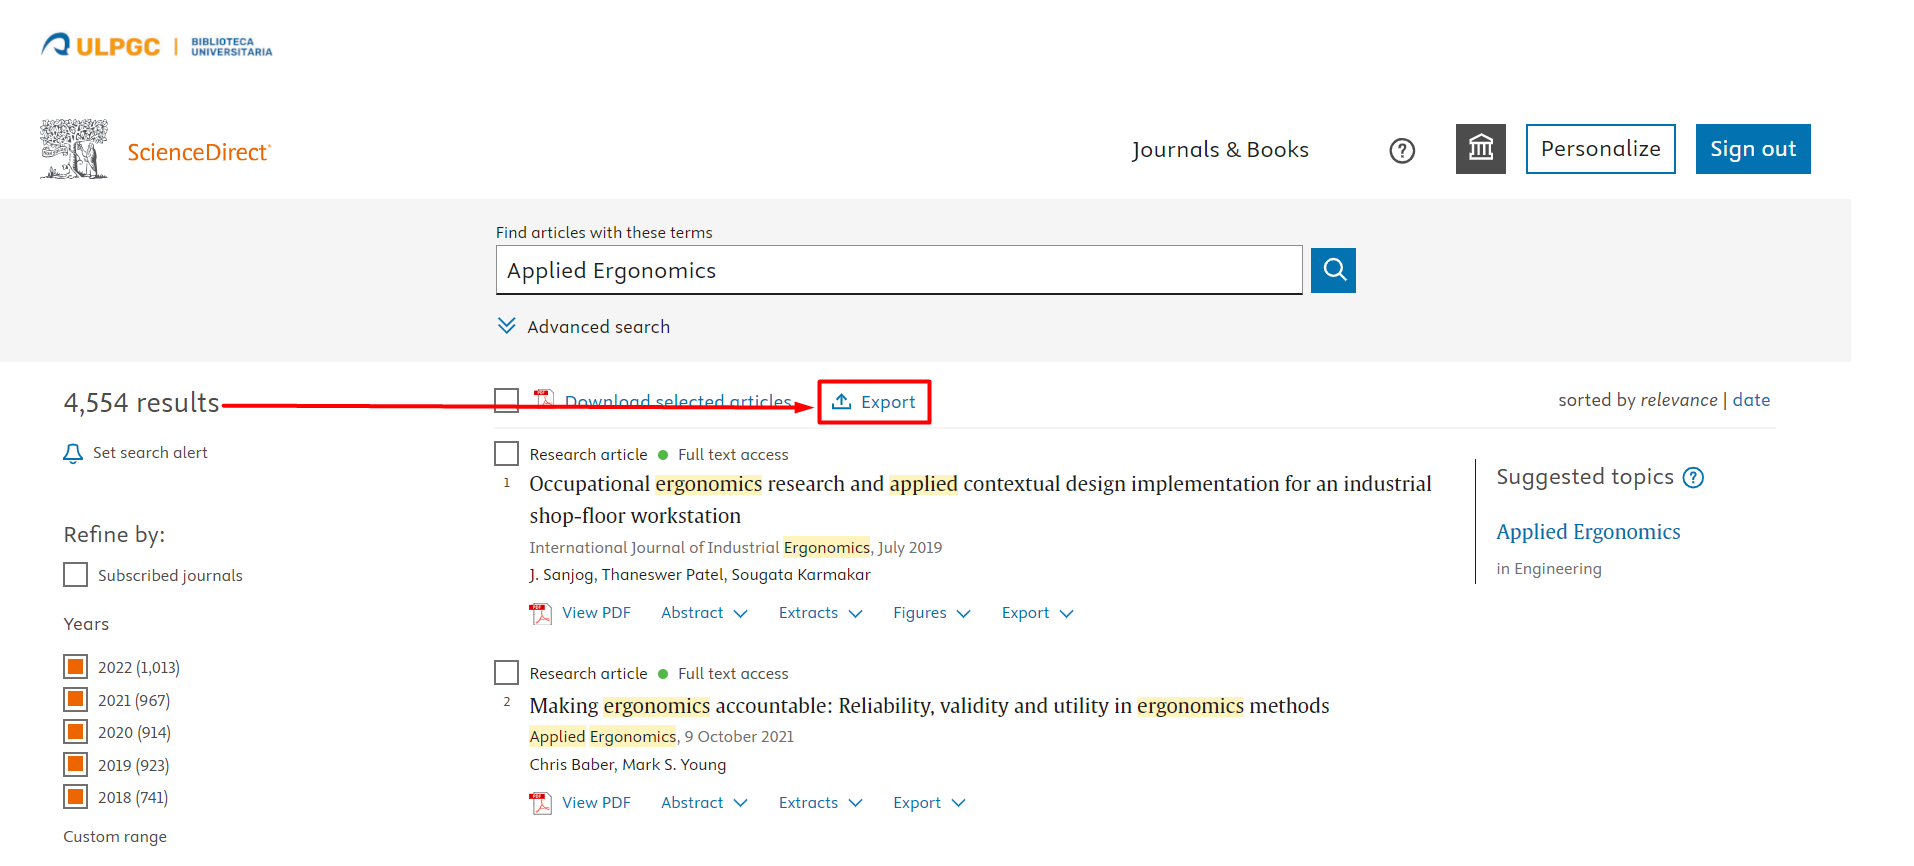

In [12]:
display(Image(filename="images/SD.png"))

Una vez obtenidas las referencias de los artículos en diferentes ficheros, en este caso con la extensión .bib correspondiente al estándar de referencia en LaTex, se empleó una máquina virtual con el sistema operativo "Linux" para concatenar el contenido de los ficheros por cada categoría del problema.

La razón de usar Linux en lugar de Windows en que el caso de la máquina anfitrión radica en el procedimiento seguido por el comando "cat" en Linux es capaz de llevar a cabo la concatenación de ficheros de forma mucho más eficaz que su contraparte en Windows, que a menudo resulta en ficheros mal codificados o de gran tamaño.

Comando utilizado para concatenar ficheros de texto en consola (para la clase 0):

> cat *.bib \> AppliedErgonomics.bib

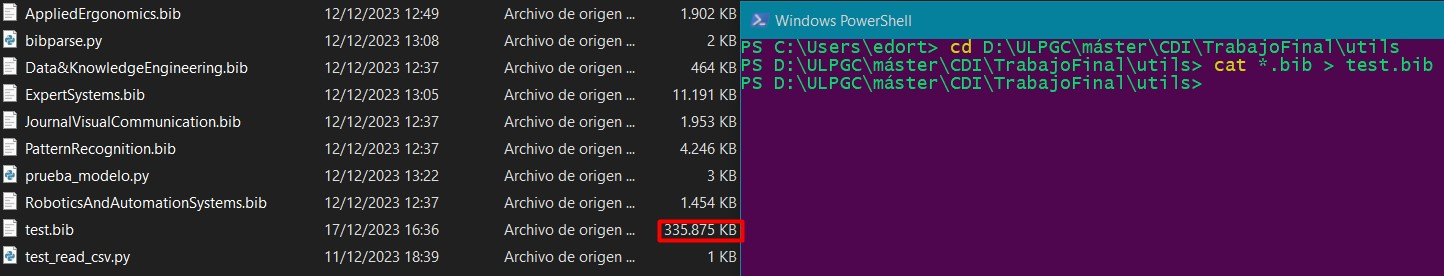

In [13]:
display(Image(filename="images/cat.jpg"))

Como se puede observar de la imagen anterior, el comando cat no ha dado buenos resultados en este caso. Los ficheros han sido, entonces, procesados con Linux.

Sin embargo, ahora es necesario construir un fichero CSV con los campos pertinentes para construir los posteriores modelos. Esto se ha hecho mediante un pequeño script que hace uso de la librería "bibtexparser" y que recorre los ficheros proporcionados construyendo el CSV correspondiente a partir de los campos requeridos, añadiendo la clase correspondiente en cada caso.

In [14]:
def convert_bibtex_to_csv(input_file_path, class_variable):
    """
    Converts a BibTeX file to a CSV file.

    Args:
        input_file_path (str): The path to the input BibTeX file.
        class_variable (str): The class variable used for the 'magazine' field in the CSV file.

    Returns:
        None
    """
    def extract_bibtex_fields(bibtex_entry):
        return {
            'title': bibtex_entry.get('title', ''),
            'abstract': bibtex_entry.get('abstract', ''),
            'keywords': bibtex_entry.get('keywords', ''),
            'magazine': str(class_variable),
        }

    with open(input_file_path, 'r', encoding='latin-1') as bibtex_file:
        parser = BibTexParser(interpolate_strings=False)
        bib_database = bibtexparser.load(bibtex_file, parser=parser)

    entries = bib_database.entries

    fieldnames = ['title', 'abstract', 'keywords', 'magazine']

    with open(f"{class_variable}.csv", 'w', encoding='latin-1', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()

        for entry in entries:
            entry_data = extract_bibtex_fields(entry)
            entry_data = {key: f'"{value}"' for key, value in entry_data.items()}
            writer.writerow(entry_data)

"""
#Ejemplo de uso

paths = ["utils\AppliedErgonomics.bib",
        "utils\JournalVisualCommunication.bib",
        "utils\PatternRecognition.bib",
        "utils\RoboticsAndAutomationSystems.bib"]

for index, path in enumerate(paths):
    convert_bibtex_to_csv(path, index)
"""

'\n#Ejemplo de uso\n\npaths = ["utils\\AppliedErgonomics.bib",\n        "utils\\JournalVisualCommunication.bib",\n        "utils\\PatternRecognition.bib",\n        "utils\\RoboticsAndAutomationSystems.bib"]\n\nfor index, path in enumerate(paths):\n    convert_bibtex_to_csv(path, index)\n'

Si concatenamos los ficheros CSV resultantes en un único dataframe, observaremos que hay casos donde el artículo científico no posee resumen/palabras clave.

In [15]:
archivos_csv = [str(i) + ".csv" for i in range(4)]
dfs = [pd.read_csv(archivo, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL) for archivo in archivos_csv]
df_completo = pd.concat(dfs, ignore_index=True)
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5365 entries, 0 to 5364
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     5365 non-null   object
 1   abstract  5361 non-null   object
 2   keywords  5308 non-null   object
 3   magazine  5365 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 167.8+ KB


En este caso, el procedimiento será eliminar las muestras con estos valores faltantes en el acto.

In [16]:
df_completo.dropna(inplace=True)
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5306 entries, 0 to 5364
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     5306 non-null   object
 1   abstract  5306 non-null   object
 2   keywords  5306 non-null   object
 3   magazine  5306 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 207.3+ KB


### Técnicas no conexionistas
Si las técnicas conexionistas son aquellas que tratan de imitar el comportamiento biológico para las tareas de clasificación, regresión, etc. Entonces las técnicas no conexionistas son aquellos algoritmos y métodos estadísticos para las mismas tareas.

Las técnicas no conexionistas usadas en esta práctica son:

- Modelo de clasificación Random Forest: es un algoritmo de aprendizaje supervisado que se basa en la construcción de múltiples árboles de decisión durante el entrenamiento y la combinación de sus resultados para mejorar la precisión y la generalización. Cada árbol en el bosque se entrena de manera independiente en una submuestra aleatoria de datos y realiza predicciones. Luego, las predicciones de todos los árboles se promedian o votan para obtener la predicción final.

- Multinomial Naive Bayes: el Clasificador Naive Bayes es un algoritmo de aprendizaje supervisado basado en el teorema de Bayes. Su variante multinomial se utiliza comúnmente para la clasificación de datos con características discretas, como recuentos de palabras en documentos.

- Máquinas de soporte vectorial (SVM): son algoritmos de aprendizaje supervisado utilizados tanto para clasificación como para regresión que buscan el hiperplano que maximiza el margen entre las clases, lo que puede conducir a una mejor generalización y resistencia al sobreajuste.

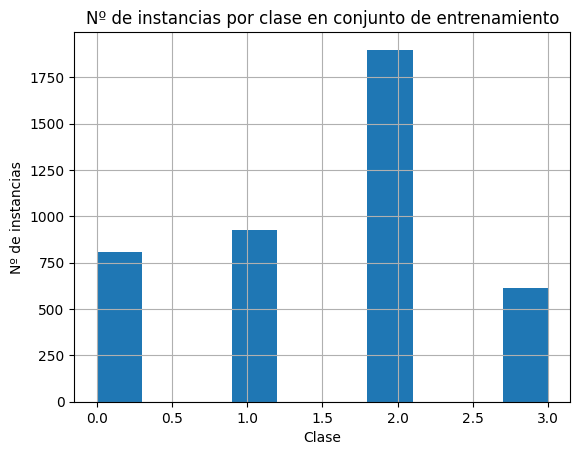

In [17]:
df_train, df_test = train_test_split(df_completo, test_size=0.2)
plt.hist(df_train["magazine"])
plt.title("Nº de instancias por clase en conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Nº de instancias")
plt.grid(True)
plt.show()

La revista "Robotics and Autonomous Systems" (3) posee considerablemente menos muestras que las demás categorías. Lo más adecuado sería realizar un _oversampling_ para balancear el dataset, añadiendo nuevas muestras a las demás clases. 

En este caso es mejor hacer un oversampling porque hay una clase con muchos más datos que las demás. El undersampling estudiado en clases anteriores tendrá mejores resultados en casos donde hay una única clase con menos datos que las demás, aunque no hay de dejar de tener en consideración el tamaño total del conjunto de datos.

En primer lugar, se tokenizará el texto y se obtendrá la matriz de términos-documentos, no sin antes normalizar los datos:

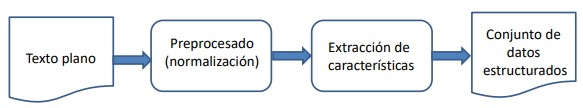

In [18]:
display(Image(filename="images/proc.jpg"))

#### Normalización de los datos
Al normalizazr los textos del conjunto de datos, estamos facilitando el aprendizaje de los modelos a construir, reduciendo la complejidad del texto al mismo tiempo que se mantiene la consistencia de la información. No afectará en gran medida a la _score_ de estos modelos, pero un incremento en este, por muy pequeño que sea, seguirá reflejándose en una mejor efectividad de las predicciones.

In [19]:
nltk.download('punkt')
nltk.download('stopwords')

df_train_X = df_train.iloc[:, :3]
df_test_X = df_test.iloc[:, :3]

df_train_y = df_train.iloc[:, 3:]
df_test_y = df_test.iloc[:, 3:]

# Convert to lowercase
df_train_X = df_train_X.apply(lambda x: x.astype(str).str.lower())
df_test_X = df_test_X.apply(lambda x: x.astype(str).str.lower())

# Remove stopwords
stopwords_list = stopwords.words('english')
df_train_X = df_train_X.apply(lambda x: x.apply(lambda words: ' '.join([w for w in words.split() if w not in stopwords_list])))
df_test_X = df_test_X.apply(lambda x: x.apply(lambda words: ' '.join([w for w in words.split() if w not in stopwords_list])))

# Remove punctuation
df_train_X = df_train_X.apply(lambda x: x.str.translate(str.maketrans('', '', string.punctuation)))
df_test_X = df_test_X.apply(lambda x: x.str.translate(str.maketrans('', '', string.punctuation)))

# Stemming
stemmer = nltk.stem.SnowballStemmer(language='english')
df_train_X = df_train_X.apply(lambda x: x.apply(lambda words: ' '.join([stemmer.stem(w) for w in words.split()])))
df_test_X = df_test_X.apply(lambda x: x.apply(lambda words: ' '.join([stemmer.stem(w) for w in words.split()])))

# Tokenize
df_train_X = df_train_X.apply(lambda x: x.apply(nltk.word_tokenize))
df_test_X = df_test_X.apply(lambda x: x.apply(nltk.word_tokenize))

# Combine words
combined_train_text = df_train_X.apply(lambda x: x.apply(lambda words: ' '.join(words)))
combined_test_text = df_test_X.apply(lambda x: x.apply(lambda words: ' '.join(words)))

train_keywords = combined_train_text['keywords']        #guardar las keywords para usarlas posteriormente
test_keywords = combined_test_text['keywords']

combined_train_text = combined_train_text['title'] + ' ' + combined_train_text['abstract'] + ' ' + combined_train_text['keywords']
combined_test_text = combined_test_text['title'] + ' ' + combined_test_text['abstract'] + ' ' + combined_test_text['keywords']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edort\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edort\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ahora el texto de las características está normalizado, lo que debería incrementar ligeramente el desempeño del modelo

In [20]:
bow = CountVectorizer(max_features=1000)
sampler = RandomOverSampler(random_state=42)

X_train = bow.fit_transform(combined_train_text).toarray()
y_train = df_train_y

X_test = bow.transform(combined_test_text).toarray()
y_test = df_test_y
print("Dimensión de la matriz TD train: ", X_train.shape)
print("Dimensión de la matriz TD test: ", X_test.shape)

Dimensión de la matriz TD train:  (4244, 1000)
Dimensión de la matriz TD test:  (1062, 1000)


d:\Programas\Anaconda\envs\neuralnetworks\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Precisión sin sampleado: 82.862524%


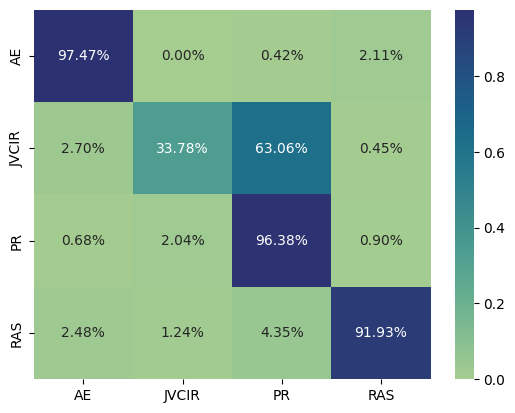

In [21]:
cls = RandomForestClassifier()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Precisión sin sampleado: {acc*100:1f}%")

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='crest', fmt=".2%", xticklabels= ["AE", "JVCIR", "PR", "RAS"], yticklabels=["AE", "JVCIR", "PR", "RAS"])
plt.show()

La matriz de confusión del modelo entrenado usando un modelo random forest pone de manifiesto una gran cantidad de falsos negativos entre los artículos pertenecientes al "Journal of Visual Communication and Image Representation" respecto a la revista "Pattern Recognition" acentuada por la vasta cantidad de muestras de esta última revista. A continuación, se emplea un RandomOverSampler para balancear el número de instancias por clase y tratar de disminuir la cantidad de falsos positivos con la clase 1.

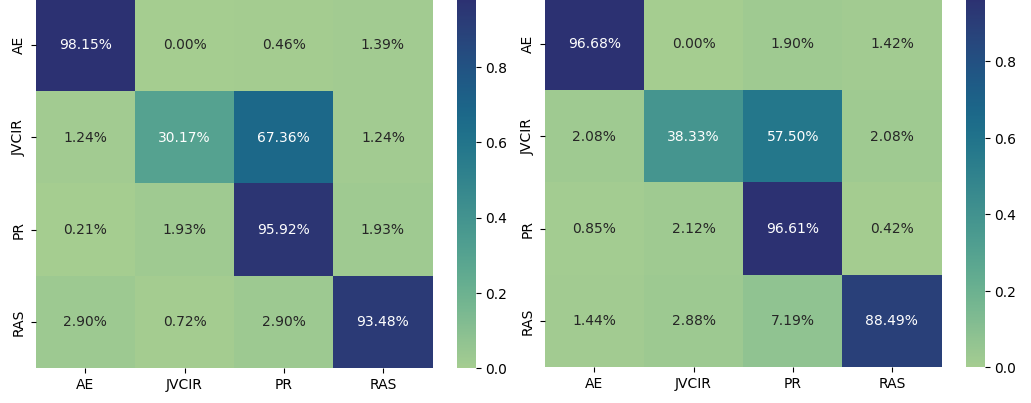

In [22]:
display(Image(filename="images/rf_tokenized_vs_rf_notokenized.png"))

A la izquierda, resultados del random forest aplicado anteriormente, normalizado. A la derecha, los resultados de un random forest sin normalizar, ambos sin el muestreo en cuestión.

Dimensión de la matriz TD train:  (7596, 1000)
Dimensión de la matriz TD test:  (1062, 1000)


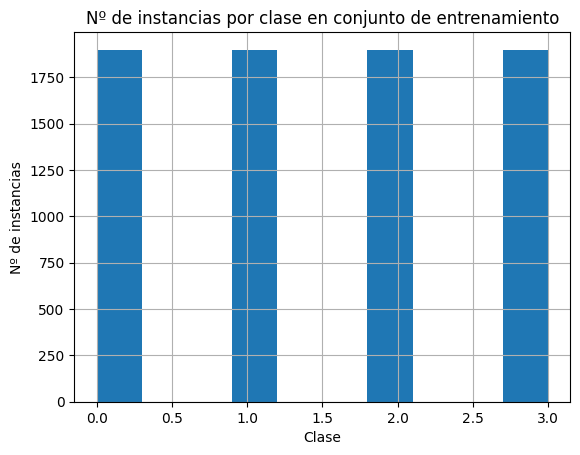

In [23]:
X_train, y_train = sampler.fit_resample(X_train, y_train)
print("Dimensión de la matriz TD train: ", X_train.shape)
print("Dimensión de la matriz TD test: ", X_test.shape)
plt.hist(y_train)
plt.title("Nº de instancias por clase en conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Nº de instancias")
plt.grid(True)
plt.show()

Ahora que las clases están balanceadas, los resultados del entrenamiento deberán ser mejores.

d:\Programas\Anaconda\envs\neuralnetworks\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Precisión con random forest: 84.651601%


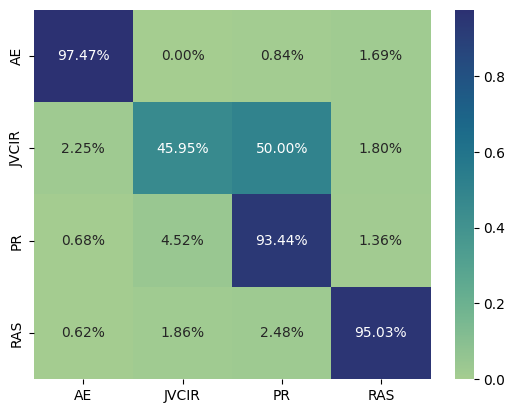

In [24]:
cls = RandomForestClassifier()
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Precisión con random forest: {acc*100:1f}%")

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='crest', fmt=".2%", xticklabels= ["AE", "JVCIR", "PR", "RAS"], yticklabels=["AE", "JVCIR", "PR", "RAS"])
plt.show()

El muestreo de las clases ha disminuido el número de falsos positivos de "Pattern Recognition". Aunque una precisión global del 83% pueda parecer un resultado óptimo, es importante tener en cuenta otras métricas que muestren mejor el desempeño del modelo como, por ejemplo, la puntuación f1:

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       237
           1       0.82      0.46      0.59       222
           2       0.78      0.93      0.85       442
           3       0.92      0.95      0.93       161

    accuracy                           0.85      1062
   macro avg       0.87      0.83      0.83      1062
weighted avg       0.85      0.85      0.83      1062



Aquí podemos observar que la puntuación del modelo respecto a la clase 1 deja mucho que desear. Una posible causa de ello es que el contenido de las revistas del "Journal of Visual Communication and Image Representation" es similar al de las revistas de "Pattern Recognition".

A continuación, se probarán otras aproximaciones no conexionistas y se compararán los resultados respecto al Random Forest:

d:\Programas\Anaconda\envs\neuralnetworks\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión (Multinomial Naive Bayes): 84.46%


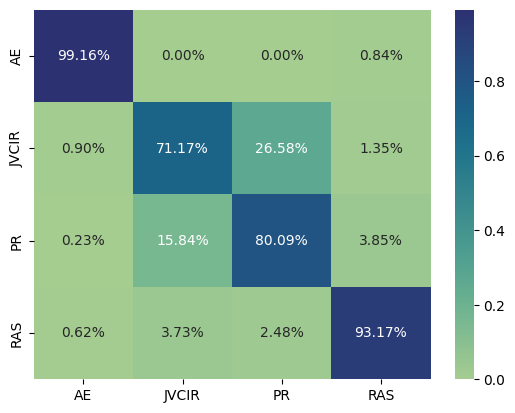

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       237
           1       0.68      0.71      0.69       222
           2       0.85      0.80      0.82       442
           3       0.87      0.93      0.90       161

    accuracy                           0.84      1062
   macro avg       0.84      0.86      0.85      1062
weighted avg       0.85      0.84      0.84      1062



d:\Programas\Anaconda\envs\neuralnetworks\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión (Support Vector Classifier): 84.37%


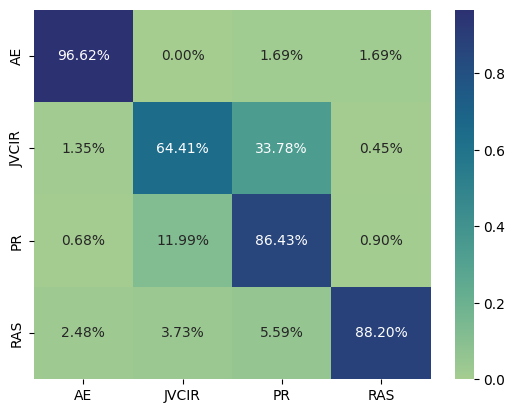

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       237
           1       0.71      0.64      0.67       222
           2       0.81      0.86      0.84       442
           3       0.94      0.88      0.91       161

    accuracy                           0.84      1062
   macro avg       0.85      0.84      0.85      1062
weighted avg       0.84      0.84      0.84      1062



In [26]:
# Multinomial Naive Bayes
nb_cls = MultinomialNB()
nb_cls.fit(X_train, y_train)
y_pred_nb = nb_cls.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Precisión (Multinomial Naive Bayes): {acc_nb*100:.2f}%")
cm = confusion_matrix(y_test, y_pred_nb)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='crest', fmt=".2%", xticklabels= ["AE", "JVCIR", "PR", "RAS"], yticklabels=["AE", "JVCIR", "PR", "RAS"])
plt.show()
print(classification_report(y_test, y_pred_nb))

# Support Vector Classifier (SVC)
svc_cls = SVC(random_state=42)
svc_cls.fit(X_train, y_train)
y_pred_svc = svc_cls.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred_svc)

print(f"Precisión (Support Vector Classifier): {acc_svc*100:.2f}%")
cm = confusion_matrix(y_test, y_pred_svc)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='crest', fmt=".2%", xticklabels= ["AE", "JVCIR", "PR", "RAS"], yticklabels=["AE", "JVCIR", "PR", "RAS"])
plt.show()
print(classification_report(y_test, y_pred_svc))

#### Conclusión de las técnicas no conexionistas

Aunque los random forests son capaces de clasificar con mucha precisión, estos carecen de la capacidad de diferenciar los artículos del "Journal of Visual Communication and Image Representation" de la categoría "Pattern Recognition". Aunque la aproximación por SVM y MNB ofrecen métricas f1 algo menores, estas últimas son capaces de distinguir mejor las clases problemáticas en ligero detrimento de las clases 0 y 3, y pueden ser una mejor opción si se busca estabilidad entre clases.

Con todo lo anterior presente, las máquinas de vectores de soporte parecen la mejor opción para abordar este problema desde el punto de vista no conexionista.

### Técnicas conexionistas

En este apartado se repite el procedimiento visto anteriormente, entrenando en este caso una red neuronal basada en una unidad LSTM, un tipo de red neuronal recurrente diseñada para manejar problemas de dependencia a largo plazo, ideal para el procesamiento de lenguaje natural. Se repite el procedimiento aplicado hasta ahora para evitar errores por el procesamiento realizado a los datos para las técnicas no conexionistas.

Epoch 1/5
236/236 [==============================] - 32s 123ms/step - loss: 0.9483 - accuracy: 0.5456 - val_loss: 1.0129 - val_accuracy: 0.5047
Epoch 2/5
236/236 [==============================] - 32s 134ms/step - loss: 0.8722 - accuracy: 0.6259 - val_loss: 0.9982 - val_accuracy: 0.4859
Epoch 3/5
236/236 [==============================] - 32s 134ms/step - loss: 0.4740 - accuracy: 0.7999 - val_loss: 0.5875 - val_accuracy: 0.7307
Epoch 4/5
236/236 [==============================] - 33s 139ms/step - loss: 0.2348 - accuracy: 0.9097 - val_loss: 0.5599 - val_accuracy: 0.7938
Epoch 5/5
34/34 [==============================] - 2s 36ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       227
           1       0.59      0.54      0.56       227
           2       0.77      0.81      0.79       453
           3       0.89      0.92      0.91       155

    accuracy                           0.80      1062
   macro avg       0.81      0.81 

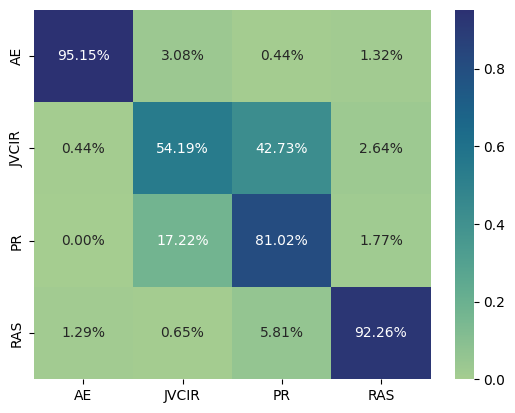

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 lstm_6 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 1080804 (4.12 MB)
Trainable params: 1080804 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
df_completo['text'] = df_completo['title'] + ' ' + df_completo['abstract'] + ' ' + df_completo['keywords']

# Normalización
df_completo['text'] = df_completo['text'].apply(lambda x: x.lower())

stopwords_list = stopwords.words('english')
df_completo['text'] = df_completo['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords_list]))

df_completo['text'] = df_completo['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

stemmer = nltk.stem.SnowballStemmer(language='english')
df_completo['text'] = df_completo['text'].apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split()]))

df_completo['text'] = df_completo['text'].apply(nltk.word_tokenize)

X_train, X_test, y_train, y_test = train_test_split(df_completo['text'], df_completo['magazine'], test_size=0.2, random_state=42)

max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_padded, y_train)

#LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=max_length))
model.add(LSTM(100))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_resampled, y_resampled, epochs=5, validation_data=(X_test_padded, y_test))

y_pred_probs = model.predict(X_test_padded)

y_pred_LSTM = y_pred_probs.argmax(axis=-1)

conf_matrix = confusion_matrix(y_test, y_pred_LSTM)

print(classification_report(y_test, y_pred_LSTM))
acc_LSTM = accuracy_score(y_test, y_pred_LSTM)
print(f"Precisión LSTM: {acc_LSTM*100:1f}%")

cm = confusion_matrix(y_test, y_pred_LSTM)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='crest', fmt=".2%", xticklabels= ["AE", "JVCIR", "PR", "RAS"], yticklabels=["AE", "JVCIR", "PR", "RAS"])
plt.show()
model.summary()

### Comparativa final y conclusiones

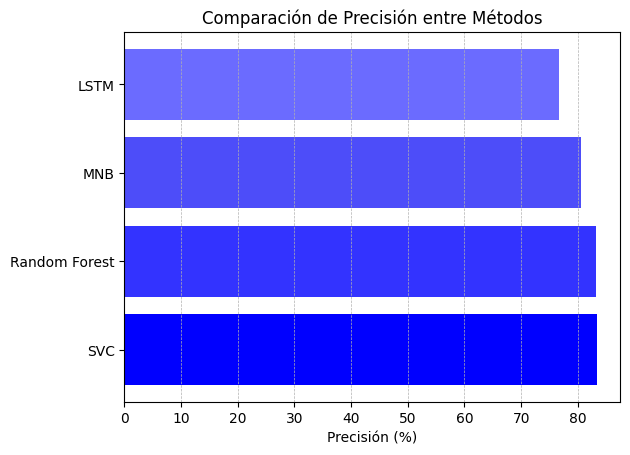

In [ ]:
methods_accuracies = {'SVC': acc_svc*100, 'Random Forest': acc*100, 'MNB': acc_nb*100, 'LSTM': acc_LSTM*100}
methods_accuracies = dict(sorted(methods_accuracies.items(), key=lambda x: x[1], reverse=True))

colors = ['#0000ff', '#3333ff', '#4d4df9', '#6b6bff']

plt.barh(list(methods_accuracies.keys()), list(methods_accuracies.values()), color=colors)
plt.xlabel('Precisión (%)')
plt.title('Comparación de Precisión entre Métodos')
plt.grid(True, axis='x', linestyle='--', linewidth=0.5)
plt.show()

Es difícil predecir con certeza qué método va a ofrecer mejores resultados en la realización de tareas como la que se aborda en este trabajo, ya que se depende de la naturaleza específica de los datos y la complejidad del problema. Aunque, generalmente, una red LSTM debería destacar en tareas de clasificación de textos debido a su capacidad para capturar patrones secuenciales, esta ha resultado ser el método menos efectivo de todos. Se observa cierta variabilidad de las métricas de evaluación entre entrenamientos.

Tras una extensa cantidad de pruebas, las máquinas de vectores de soporte y los random forest resultan las técnicas más efectivas para abordar este problema concreto gracias la calidad y la cantidad de características relevantes en los datos del problema. No obstante, no se descartan posibles mejores configuraciones de la red LSTM que permitan obtener mejores predicciones que los demás métodos estudiados en este trabajo.